## Libraries Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



## Loading the Dataset

In [2]:
df= pd.read_csv("Real_Estate_Sales_2001-2023_GL.csv")
df.head(10)

C:\Users\sonke\AppData\Local\Temp\ipykernel_14580\936231715.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("Real_Estate_Sales_2001-2023_GL.csv")


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000,248400.0,0.535400,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500,239900.0,0.460600,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500,325000.0,0.463000,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400,202500.0,0.629100,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990,362500.0,0.496500,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)
5,200500,2020,09-07-2021,Avon,245 NEW ROAD,217640,400000.0,0.544100,Residential,Single Family,NaN,NaN,NaN,NaN
6,200121,2020,12/15/2020,Avon,63 NORTHGATE,528490,775000.0,0.681900,Residential,Single Family,NaN,NaN,NaN,POINT (-72.89675 41.79445)
7,20058,2020,06-01-2021,Barkhamsted,46 RATLUM MTN RD,203530,415000.0,0.490434,Residential,Single Family,NaN,"2003 COLONIAL, 2140 SFLA, 2.99 AC",NaN,NaN
8,200046,2020,01/25/2021,Beacon Falls,34 LASKY ROAD,158030,243000.0,0.650300,Residential,Single Family,NaN,NaN,NaN,NaN
9,200016,2020,11/13/2020,Beacon Falls,9 AVON COURT,65590,100000.0,0.655900,Residential,Condo,NaN,NaN,NaN,NaN


## Data Cleaning

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.drop_duplicates()
df_clean = df[df['non_use_code'].isna()].copy()
df_clean = df_clean[df_clean['sale_amount'] > 2000]
df_clean = df_clean[(df_clean['sales_ratio'] > 0.05) & (df_clean['sales_ratio'] 


df_clean['date_recorded'] = pd.to_datetime(df_clean['date_recorded'], format='mixed')


df_clean['sale_year'] = df_clean['date_recorded'].dt.year

print(f"Data Shape after cleaning: {df_clean.shape}")

Data Shape after cleaning: (747784, 15)


In [4]:
print(df_clean.isnull().sum())

serial_number            0
list_year                0
date_recorded            0
town                     0
address                  1
assessed_value           0
sale_amount              0
sales_ratio              0
property_type       277675
residential_type    283678
non_use_code        747784
assessor_remarks    708000
opm_remarks         745693
location            560964
sale_year                0
dtype: int64


## Handling Missing Values

In [5]:
df_clean['residential_type'] = df_clean['residential_type'].fillna('Not Applicable')

df_clean['property_type'] = df_clean['property_type'].fillna(df_clean['property_type'].mode()[0])


cols_to_drop = ['non_use_code', 'assessor_remarks', 'opm_remarks', 'location', 'address']
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])

df_clean = df_clean.dropna(subset=['sale_amount', 'assessed_value'])

print("Null values handled.")
print(df_clean.isnull().sum())

Null values handled.
serial_number       0
list_year           0
date_recorded       0
town                0
assessed_value      0
sale_amount         0
sales_ratio         0
property_type       0
residential_type    0
sale_year           0
dtype: int64


## Exploratory Data Analysis

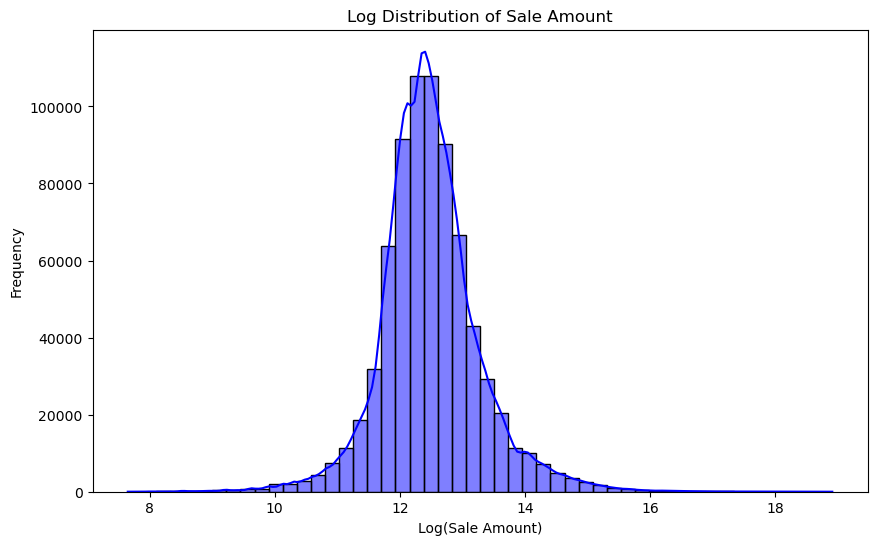

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_clean['sale_amount']), bins=50, kde=True, color='blue')
plt.title('Log Distribution of Sale Amount')
plt.xlabel('Log(Sale Amount)')
plt.ylabel('Frequency')
plt.show()

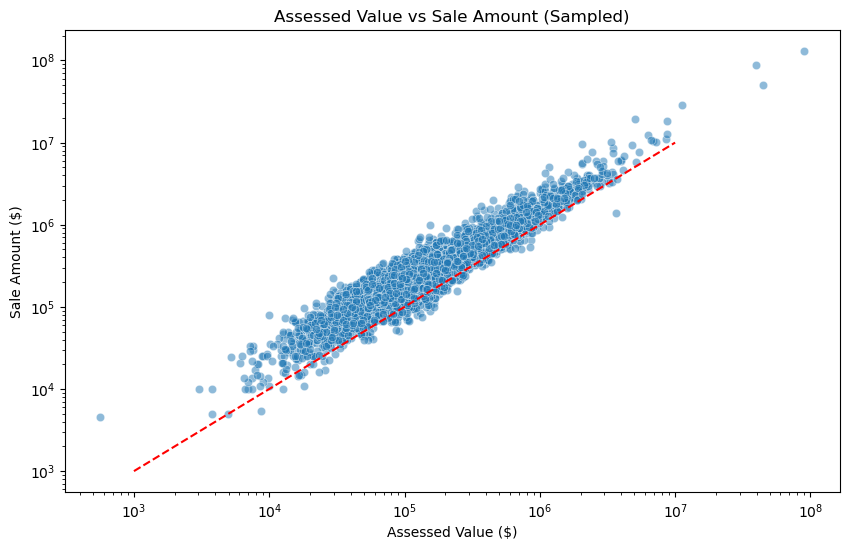

In [7]:
sample_df = df_clean.sample(min(10000, len(df_clean)), random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='assessed_value', y='sale_amount', data=sample_df, alpha=0.5)
plt.title('Assessed Value vs Sale Amount (Sampled)')
plt.xlabel('Assessed Value ($)')
plt.ylabel('Sale Amount ($)')
plt.xscale('log')
plt.yscale('log')
plt.plot([1000, 10000000], [1000, 10000000], 'r--') 
plt.show()

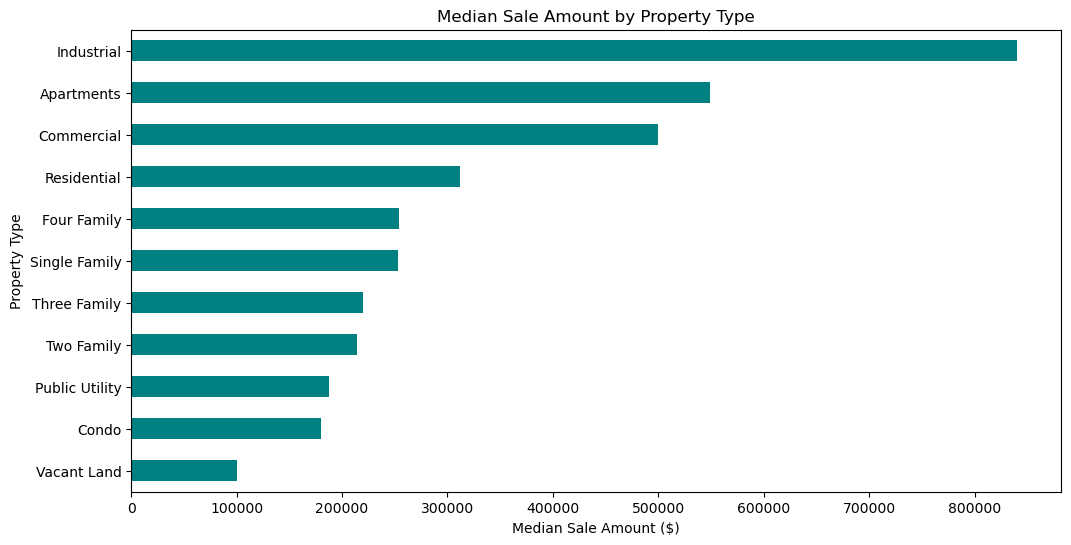

In [8]:
plt.figure(figsize=(12, 6))
avg_price_prop = df_clean.groupby('property_type')['sale_amount'].median().sort_values()
avg_price_prop.plot(kind='barh', color='teal')
plt.title('Median Sale Amount by Property Type')
plt.xlabel('Median Sale Amount ($)')
plt.ylabel('Property Type')
plt.show()

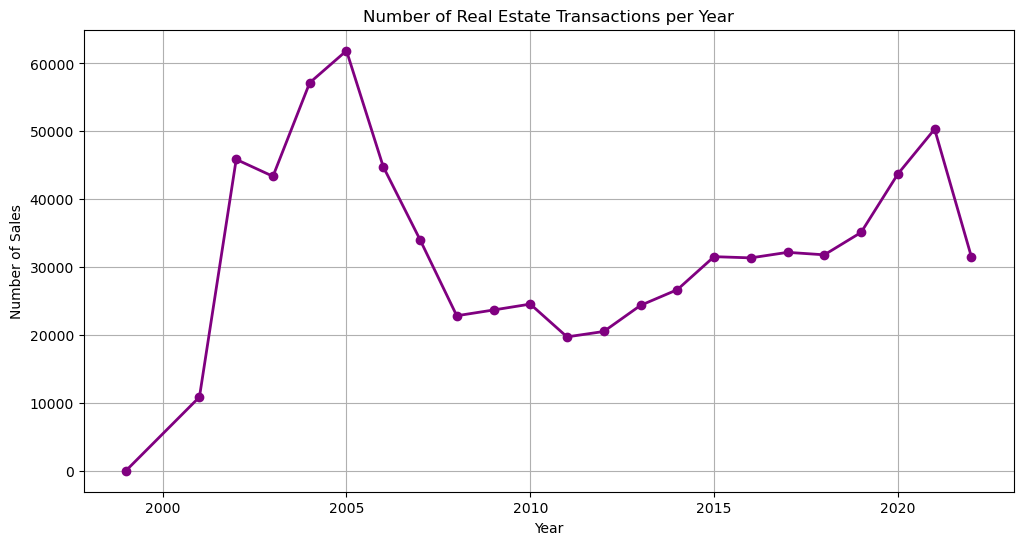

In [9]:
plt.figure(figsize=(12, 6))
df_clean['sale_year'].value_counts().sort_index().plot(kind='line', marker='o', color='purple', linewidth=2)
plt.title('Number of Real Estate Transactions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Sales')
plt.grid(True)
plt.show()

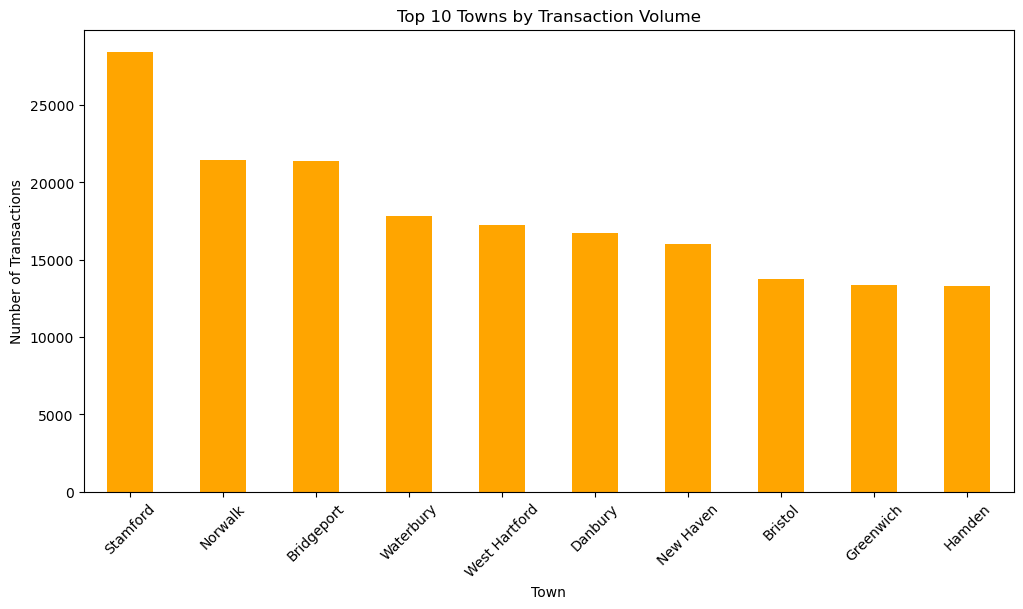

In [10]:
plt.figure(figsize=(12, 6))
df_clean['town'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Towns by Transaction Volume')
plt.xlabel('Town')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

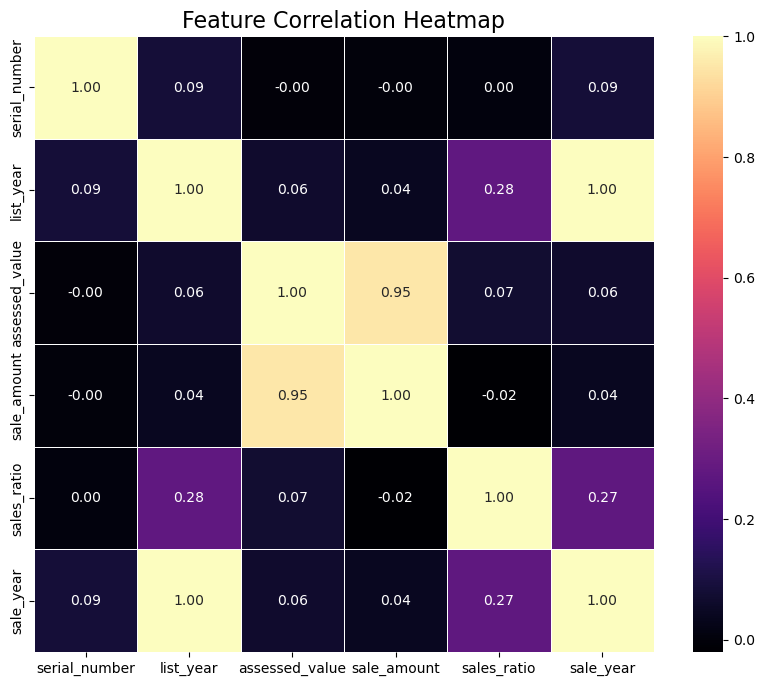

In [11]:
numeric_df = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))

corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

## Model Comparision

Training Models... (This may take a moment)
Running Linear Regression...
Running Decision Tree...
Running Random Forest...
Running XGBoost...

FINAL MODEL COMPARISON RESULTS
               Model           MAE           RMSE  R2 Score
2      Random Forest  65353.369061  404604.039571  0.905573
0  Linear Regression  84695.868680  448105.229741  0.884177
1      Decision Tree  82276.079380  491267.712987  0.860789
3            XGBoost  84195.667178  969559.466331  0.457769


C:\Users\sonke\AppData\Local\Temp\ipykernel_14580\509098031.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=results_df, palette='viridis')


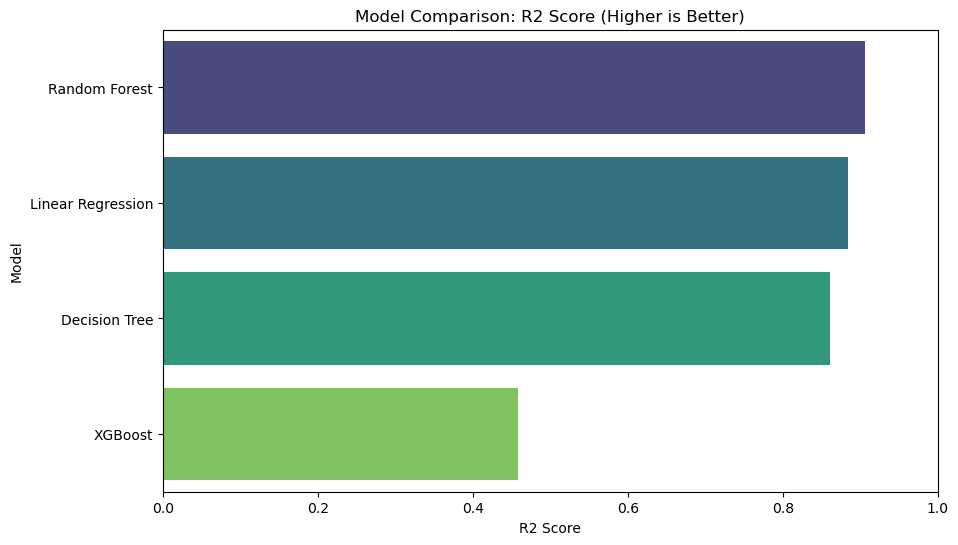

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # Imported MAE


features = ['list_year', 'town', 'assessed_value', 'property_type', 'residential_type']
target = 'sale_amount'

X = df_clean[features]
y = df_clean[target]


numerical_cols = ['list_year', 'assessed_value']
categorical_cols = ['town', 'property_type', 'residential_type']

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, n_jobs=-1)
}


results = []
print("Training Models... (This may take a moment)")

for name, model in models.items():
    print(f"Running {name}...")
    
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', model)])
    
    
    model_pipeline.fit(X_train, y_train)
    
    
    y_pred = model_pipeline.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)        # NEW: MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2})


results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

print("\n" + "="*40)
print("FINAL MODEL COMPARISON RESULTS")
print("="*40)
print(results_df)

# 7. Visualize R2 Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 Score', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: R2 Score (Higher is Better)')
plt.xlim(0, 1)
plt.show()

## Prediction Model

In [13]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1))
])


print("Finalizing Random Forest Model...")
final_model.fit(X_train, y_train)
print("Model Ready!")

def predict_house_price(list_year, town, assessed_value, property_type, residential_type):
    """
    Creates a dataframe for a single house and predicts the sale price.
    """
  
    input_data = pd.DataFrame({
        'list_year': [list_year],
        'town': [town],
        'assessed_value': [assessed_value],
        'property_type': [property_type],
        'residential_type': [residential_type]
    })
    
   
    prediction = final_model.predict(input_data)[0]
    
    return prediction

my_house_prediction = predict_house_price(
    list_year=2021,
    town='Stamford',
    assessed_value=300000,
    property_type='Residential',
    residential_type='Single Family'
)

print("\n" + "="*40)
print(f"PREDICTED SALE PRICE: ${my_house_prediction:,.2f}")
print("="*40)

Finalizing Random Forest Model...
Model Ready!

PREDICTED SALE PRICE: $571,276.88


In [16]:
print(df["town"].unique())

['Ansonia' 'Avon' 'Barkhamsted' 'Beacon Falls' 'Berlin' 'Bethel'
 'Bethlehem' 'Bolton' 'Branford' 'Bristol' 'Bridgeport' 'Brookfield'
 'Burlington' 'Canton' 'Cheshire' 'Colchester' 'Coventry' 'Cromwell'
 'Danbury' 'Colebrook' 'Darien' 'Derby' 'East Granby' 'East Haddam'
 'East Hartford' 'East Haven' 'East Lyme' 'East Hampton' 'Easton'
 'East Windsor' 'Enfield' 'Essex' 'Farmington' 'Fairfield' 'Franklin'
 'Glastonbury' 'Goshen' 'Granby' 'Greenwich' 'Guilford' 'Hamden'
 'Griswold' 'Groton' 'Kent' 'Hartford' 'Litchfield' 'Harwinton'
 'Killingly' 'Middletown' 'Killingworth' 'Lebanon' 'Lisbon' 'Madison'
 'Manchester' 'New Britain' 'Mansfield' 'Meriden' 'Middlebury' 'New Haven'
 'Milford' 'Monroe' 'Montville' 'Newtown' 'Naugatuck' 'North Stonington'
 'Norwalk' 'New Canaan' 'New Fairfield' 'Norwich' 'Old Saybrook'
 'New London' 'Plainfield' 'North Canaan' 'Portland' 'North Haven'
 'Ridgefield' 'Simsbury' 'Somers' 'Old Lyme' 'Orange' 'Plainville'
 'South Windsor' 'Plymouth' 'Preston' 'Putnam' 

In [17]:
print(df["assessed_value"].unique())

[ 133000  110500  150500 ... 1670450  789900  776500]


In [18]:
print(df["property_type"].unique())

['Residential' 'Commercial' 'Vacant Land' 'Public Utility' 'Apartments'
 'Industrial' nan 'Condo' 'Two Family' 'Single Family' 'Three Family'
 'Four Family']


In [19]:
print(df["residential_type"].unique())

['Single Family' 'Three Family' nan 'Two Family' 'Condo' 'Four Family']


## Testing 

In [20]:
my_house_prediction = predict_house_price(
    list_year=2019,
    town='Somers',
    assessed_value=196000,
    property_type='Commercial',
    residential_type='Condo'
)

print("\n" + "="*40)
print(f"PREDICTED SALE PRICE: ${my_house_prediction:,.2f}")
print("="*40)


PREDICTED SALE PRICE: $302,178.22


## Saving the Model

In [14]:
import joblib

model_filename = 'real_estate_pipeline_v1.pkl'
joblib.dump(final_model, 'real_estate_pipeline_v1.pkl', compress=3)

print(f"Model saved successfully as {model_filename}")


loaded_model = joblib.load(model_filename)

test_input = pd.DataFrame({
    'list_year': [2021],
    'town': ['Stamford'],
    'assessed_value': [300000],
    'property_type': ['Residential'],
    'residential_type': ['Single Family']
})

prediction = loaded_model.predict(test_input)[0]

print("="*40)
print(f"Loaded Model Prediction: ${prediction:,.2f}")
print("="*40)

Model saved successfully as real_estate_pipeline_v1.pkl
Loaded Model Prediction: $571,276.88
